In [1]:
import pandas as pd
import numpy as np
import os, pickle, janitor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


## For the scraping
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

In [2]:
## Get Location Code from the Data Frame
def getLocationCode(text):
    return text.split("/")[-1]

## Apply it to a Pandas Series
def getLocationCodeSeries(pd_series):
    return pd_series.apply(getLocationCode)

## Get the Data Frame
def getUnitDataFrame(path: str):
    df = (
        pd.read_csv(path)
        .pipe(janitor.clean_names, strip_underscores=True)
        .assign(date=lambda x: pd.to_datetime(x.date),
                location=lambda x: getLocationCodeSeries(x.location))
        .drop(columns=["unnamed_0", "actual_time", "dew_point"])
        .rename(columns={"high_temp": "temp_max",
                         "low_temp": "temp_min",
                         "day_average_temp": "temp_mean",
                         "high": "dew_point_max",
                         "low": "dew_point_min",
                         "average": "dew_point_mean",
                         "visibiilty": "visibility",})
    )
    return df

## GET all the Data Frames
def getDataFrame(folder_path: str):
    files = os.listdir(folder_path)
    df = pd.concat([getUnitDataFrame(folder_path + file) for file in files])
    return df

In [3]:
ogdf = getDataFrame('data/')
mydf = ogdf.copy()

## Datacleaning

In [52]:
mydf.describe()

,temp_max,temp_min,temp_mean,precipitation,dew_point_max,dew_point_min,dew_point_mean,max_wind_speed,visibility,sea_level_pressure
count,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000,5242.000000
mean,57.472720,41.945441,49.482167,0.081127,43.276421,32.603968,38.210401,14.841282,10.028615,29.401114
std,16.860057,15.866311,15.658033,0.292928,15.500358,16.465049,15.692852,6.763031,0.841096,1.095629
min,3.000000,-7.000000,-0.190000,0.000000,-8.000000,-15.000000,-10.590000,0.000000,3.000000,25.310000
25%,45.000000,31.000000,38.262500,0.000000,32.000000,22.000000,27.292500,10.000000,10.000000,29.220000
50%,57.000000,40.000000,47.990000,0.000000,42.000000,30.000000,36.330000,14.000000,10.000000,29.740000
75%,70.000000,51.000000,59.637500,0.010000,54.000000,42.000000,47.837500,18.000000,10.000000,30.080000
max,201.000000,82.000000,84.380000,8.170000,199.000000,76.000000,76.750000,200.000000,20.000000,30.760000


In [53]:
mydf[mydf['temp_max'] == 201]

,location,date,temp_max,temp_min,temp_mean,precipitation,dew_point_max,dew_point_min,dew_point_mean,max_wind_speed,visibility,sea_level_pressure
3317,KSWF,2019-11-03,201,34,48.42,0.0,36,28,31.25,18,20,29.75


In [4]:
mydf.loc[3317, 'temp_max'] = 50

In [55]:
mydf[mydf['temp_min'] == 0]

,location,date,temp_max,temp_min,temp_mean,precipitation,dew_point_max,dew_point_min,dew_point_mean,max_wind_speed,visibility,sea_level_pressure
361,KSFO,2020-12-01,62,0,49.00,0.00,48,0,43.95,20,10,30.27
733,KSEA,2022-11-25,49,0,41.78,0.00,46,0,38.89,21,10,29.94
942,KDCA,2021-11-09,71,0,53.92,0.00,46,0,41.54,10,10,30.21
1379,KPWM,2019-10-27,50,0,42.85,0.00,46,0,38.89,17,10,30.13
2274,KMIA,2020-11-13,86,0,73.86,1.31,76,0,70.30,8,10,30.03
2432,KMIA,2023-11-18,79,0,72.03,0.00,70,0,64.55,12,10,29.80
2439,KMIA,2023-11-25,83,0,74.84,0.02,71,0,67.38,12,10,30.09
2476,KMIA,2024-11-11,85,0,76.92,0.01,75,0,70.36,10,10,29.94
3341,KSWF,2019-11-27,54,0,44.14,0.00,50,0,41.61,22,10,29.53
3358,KSWF,2019-12-14,48,0,41.73,0.00,48,0,41.27,32,10,29.36


In [5]:
missing_min = mydf[mydf['temp_min'] == 0]  # Example subset, you can define your own subset
missing_min_location = missing_min['location'].tolist()
missing_min_date = missing_min['date'].tolist()
missing_min_rows = missing_min.index.tolist()

In [6]:
min_refills = [36, # KSFO 2020-12-01
               43, # KSEA 2022-11-25
               38, # KDCA 2021-11-09
               45, # KPWM 2019-10-27
               73, # KMIA 2020-11-13
               72, # KMIA 2023-11-18
               73, # KMIA 2023-11-25
               75, # KMIA 2024-11-11
               36, # KSWF 2019-11-27
               39, # KSWF 2019-12-14
               30, # KSWF 2020-11-17
               41, # KSWF 2020-11-21
               46, # KSWF 2020-11-27
               37, # KSWF 2020-11-28
               30, # KSWF 2020-12-03
               43, # KSWF 2021-12-16
               39, # KSWF 2022-11-03
               32, # KSWF 2024-11-16
               0, # PANC 2020-12-05
               0, # PANC 2021-11-16
               0,# PANC 2022-11-28
               0, # PANC 2022-11-07
               33, # KBOI 2019-11-13
               32 # KBOI 2021-12-02
               ] 

In [7]:
# Refill unreasonable values
for i in range(len(missing_min_rows)):
    mydf.loc[missing_min_rows[i], 'temp_min'] = min_refills[i]
    print(missing_min_location[i], missing_min_date[i],'refilled with temp_min= ', min_refills[i])


KSFO 2020-12-01 00:00:00 refilled with temp_min=  36
KSEA 2022-11-25 00:00:00 refilled with temp_min=  43
KDCA 2021-11-09 00:00:00 refilled with temp_min=  38
KPWM 2019-10-27 00:00:00 refilled with temp_min=  45
KMIA 2020-11-13 00:00:00 refilled with temp_min=  73
KMIA 2023-11-18 00:00:00 refilled with temp_min=  72
KMIA 2023-11-25 00:00:00 refilled with temp_min=  73
KMIA 2024-11-11 00:00:00 refilled with temp_min=  75
KSWF 2019-11-27 00:00:00 refilled with temp_min=  36
KSWF 2019-12-14 00:00:00 refilled with temp_min=  39
KSWF 2020-11-17 00:00:00 refilled with temp_min=  30
KSWF 2020-11-21 00:00:00 refilled with temp_min=  41
KSWF 2020-11-27 00:00:00 refilled with temp_min=  46
KSWF 2020-11-28 00:00:00 refilled with temp_min=  37
KSWF 2020-12-03 00:00:00 refilled with temp_min=  30
KSWF 2021-12-16 00:00:00 refilled with temp_min=  43
KSWF 2022-11-03 00:00:00 refilled with temp_min=  39
KSWF 2024-11-16 00:00:00 refilled with temp_min=  32
PANC 2020-12-05 00:00:00 refilled with temp_mi

In [10]:
mydf.to_csv('data/data_cleaned.csv')

## EDA

### Time Series Analysis

/var/folders/gt/gss6fsxj4g3cs1mbwhzwdj8w0000gs/T/ipykernel_31771/2779209690.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  city_data = mydf[mydf['location'] == city][mydf['year'] == 2023]
/var/folders/gt/gss6fsxj4g3cs1mbwhzwdj8w0000gs/T/ipykernel_31771/2779209690.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  city_data = mydf[mydf['location'] == city][mydf['year'] == 2023]
/var/folders/gt/gss6fsxj4g3cs1mbwhzwdj8w0000gs/T/ipykernel_31771/2779209690.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  city_data = mydf[mydf['location'] == city][mydf['year'] == 2023]
/var/folders/gt/gss6fsxj4g3cs1mbwhzwdj8w0000gs/T/ipykernel_31771/2779209690.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  city_data = mydf[mydf['location'] == city][mydf['year'] == 2023]
/var/folders/gt/gss6fsxj4g3cs1mbwhzwdj8w0000gs/T/ipykernel_31771/2779209690.py:8: UserWarning: Boole

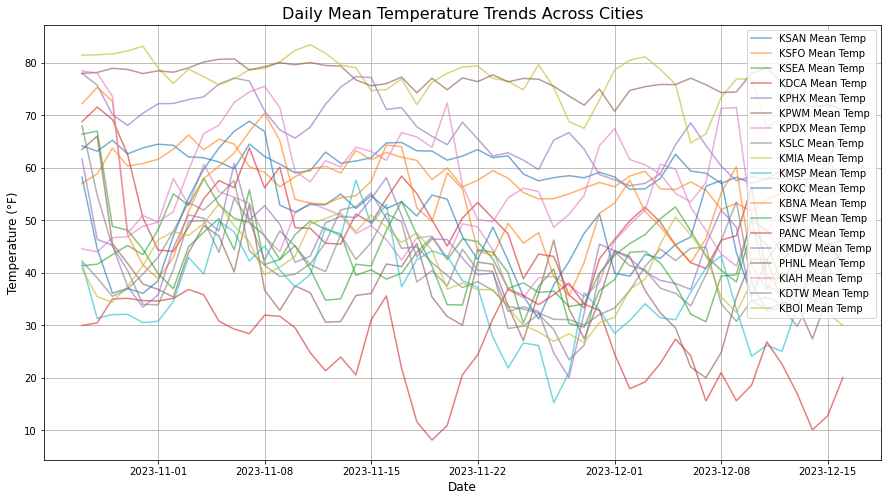

In [19]:
import matplotlib.pyplot as plt
mydf['date'] = pd.to_datetime(mydf['date'])
mydf['year']= mydf['date'].dt.year
cities = mydf['location'].unique()

plt.figure(figsize=(15, 8))
for city in cities:
    city_data = mydf[mydf['location'] == city][mydf['year'] == 2023]
    plt.plot(city_data['date'], city_data['temp_mean'], label=f'{city} Mean Temp', alpha=0.6)

plt.title("Daily Mean Temperature Trends Across Cities", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature (°F)", fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid()
plt.show()


### Correlations

/usr/local/anaconda/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/usr/local/anaconda/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


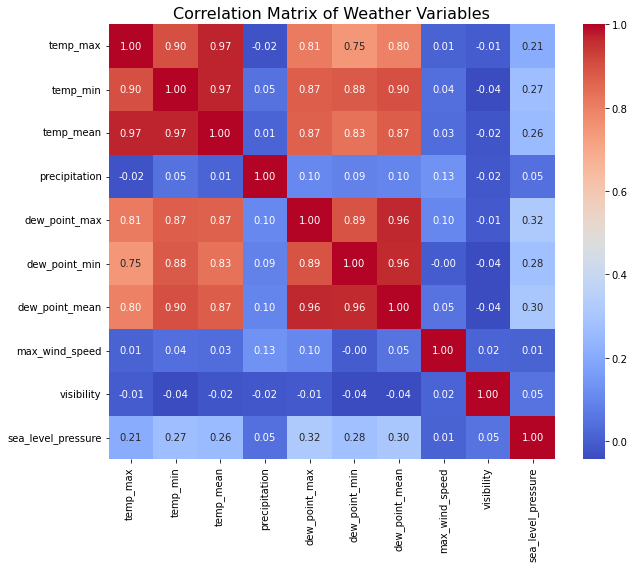

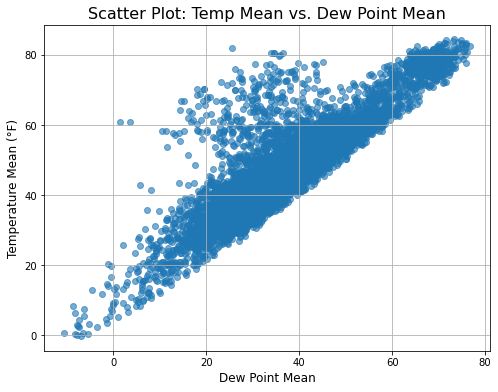

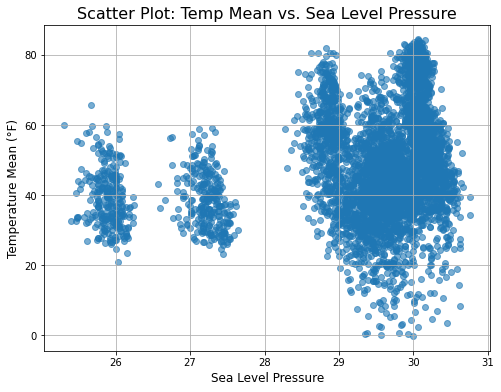

In [20]:
import seaborn as sns

numerical_columns = ['temp_max', 'temp_min', 'temp_mean', 'precipitation', 
                     'dew_point_max', 'dew_point_min', 'dew_point_mean', 
                     'max_wind_speed', 'visibility', 'sea_level_pressure']
correlation_data = mydf[numerical_columns]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Weather Variables", fontsize=16)
plt.show()

# Scatter plots for key correlations (Example)
# Plot temp_mean vs. dew_point_mean
plt.figure(figsize=(8, 6))
plt.scatter(mydf['dew_point_mean'], mydf['temp_mean'], alpha=0.6)
plt.title("Scatter Plot: Temp Mean vs. Dew Point Mean", fontsize=16)
plt.xlabel("Dew Point Mean", fontsize=12)
plt.ylabel("Temperature Mean (°F)", fontsize=12)
plt.grid()
plt.show()

# Plot temp_mean vs. sea_level_pressure
plt.figure(figsize=(8, 6))
plt.scatter(mydf['sea_level_pressure'], mydf['temp_mean'], alpha=0.6)
plt.title("Scatter Plot: Temp Mean vs. Sea Level Pressure", fontsize=16)
plt.xlabel("Sea Level Pressure", fontsize=12)
plt.ylabel("Temperature Mean (°F)", fontsize=12)
plt.grid()
plt.show()


### City-wise Analysis


City-wise Weather Summary:
   location  temp_min_median  temp_min_std  temp_mean_median  temp_mean_std  \
0      KBNA             40.0     10.545632            51.660       9.522236   
1      KBOI             31.0      7.341868            37.590       7.900232   
2      KDCA             40.0      8.470620            48.590       8.665412   
3      KDTW             33.0      8.840829            40.115       9.478354   
4      KIAH             52.0     10.236062            62.390       9.185925   
5      KMDW             34.0      9.818082            41.080      10.302048   
6      KMIA             72.0      6.125521            76.520       4.809774   
7      KMSP             29.0     10.785915            34.060      11.108141   
8      KOKC             37.0      9.741802            48.440       9.606648   
9      KPDX             41.0      6.521472            45.740       5.741638   
10     KPHX             54.0      6.916119            63.540       7.524092   
11     KPWM             3

<Figure size 1080x576 with 0 Axes>

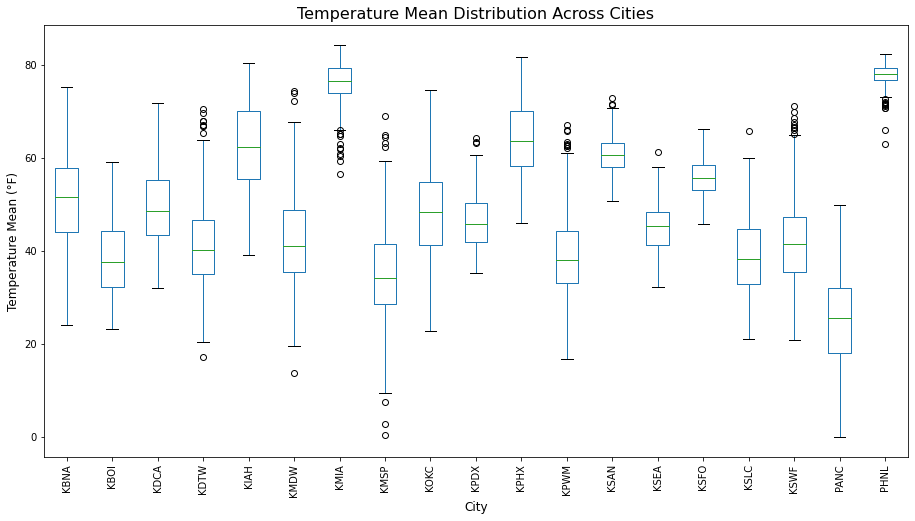

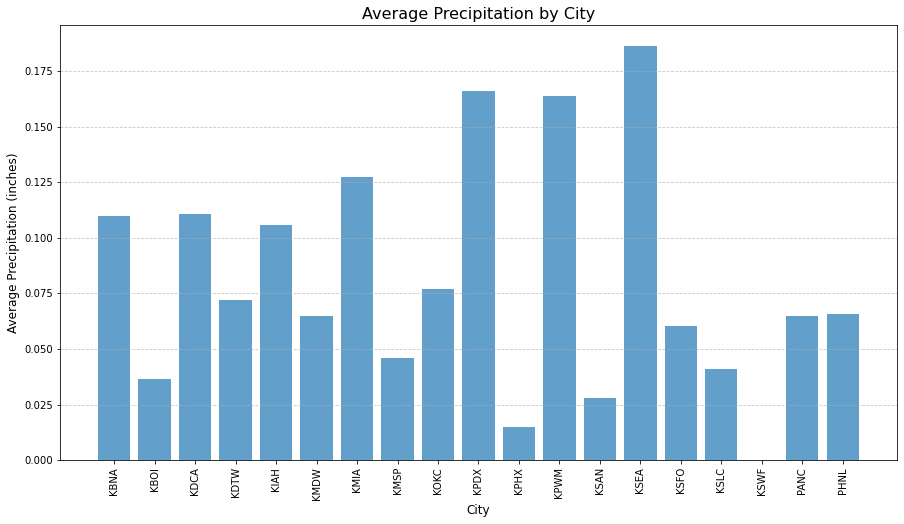

In [24]:

city_summary = mydf.groupby('location').agg({
    'temp_min': [ 'median', 'std'],
    'temp_mean': [ 'median', 'std'],
    'temp_max': ['median', 'std'],
    'precipitation': 'mean',
    'max_wind_speed': 'mean'
}).reset_index()


city_summary.columns = ['_'.join(col).strip('_') for col in city_summary.columns]

print("City-wise Weather Summary:")
print(city_summary)

# Boxplot for temperature distributions across cities
plt.figure(figsize=(15, 8))
mydf.boxplot(column='temp_mean', by='location', grid=False, rot=90, figsize=(15, 8))
plt.title("Temperature Mean Distribution Across Cities", fontsize=16)
plt.xlabel("City", fontsize=12)
plt.ylabel("Temperature Mean (°F)", fontsize=12)
plt.suptitle("")  # Remove automatic title
plt.show()

# Bar chart: Average precipitation across cities
city_avg_precipitation = mydf.groupby('location')['precipitation'].mean().reset_index()

plt.figure(figsize=(15, 8))
plt.bar(city_avg_precipitation['location'], city_avg_precipitation['precipitation'], alpha=0.7)
plt.title("Average Precipitation by City", fontsize=16)
plt.xlabel("City", fontsize=12)
plt.ylabel("Average Precipitation (inches)", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()




### Map

In [26]:
!pip3 install geopandas

     |████████████████████████████████| 323 kB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 5.3 MB 70.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 20.1 MB/s eta 0:00:01
     |████████████████████████████████| 15.1 MB 123.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 60.7 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 2.0.2 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 2.0.2 which is incompatible.


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Example city coordinates (you'll need latitude and longitude for each city)
city_coordinates = {
    'location': ['KBNA', 'KBOI', 'KDCA','KDTW','KIAH','KMDW','KMIA','KMSP','KOKC',
                 'KPDX','KPHX','KPWM','KSAN','KSEA','KSFO','KSLC','KSWF','PANC','PHML'],  # Replace with actual cities
    'latitude': [36.12, 43.56, 38.85,42.21, 29.99,41.79,25.79,44.89,35.39,
                 45.59,33.44,43.65,32.73,47.45,37.62,40.79,41.50,61.18,42.98],       # Replace with actual latitudes
    'longitude': [-68, -116.21, -77.04,-83.35, -95.34,-87.75,-80.28,-93.21,-97.60,
                  -122.59,-112.01,-70.31,-117.19,-122.31,-122.38,-111.98,-74.10, -149.99,-82.43]  # Replace with actual longitudes
}
city_coords_df = pd.DataFrame(city_coordinates)

# Add average temperature for each city
city_avg_temp = mydf.groupby('location')['temp_mean'].mean().reset_index()
city_map_data = city_coords_df.merge(city_avg_temp, on='location')

In [37]:
city_map_data

,location,latitude,longitude,temp_mean
0,KBNA,36.12,-68.00,51.343491
1,KBOI,43.56,-116.21,38.611884
2,KDCA,38.85,-77.04,49.787862
3,KDTW,42.21,-83.35,41.144058
4,KIAH,29.99,-95.34,62.421703
5,KMDW,41.79,-87.75,42.372790
6,KMIA,25.79,-80.28,76.039819
7,KMSP,44.89,-93.21,34.969638
8,KOKC,35.39,-97.60,48.505362
9,KPDX,45.59,-122.59,46.315942


In [43]:
!pip3 show geopandas

Name: geopandas
Version: 1.0.1
Summary: Geographic pandas extensions
Home-page: 
Author: 
Author-email: Kelsey Jordahl <kjordahl@alum.mit.edu>
License: BSD 3-Clause
Location: /usr/local/anaconda/lib/python3.9/site-packages
Requires: pyogrio, numpy, packaging, shapely, pandas, pyproj
Required-by: 


In [38]:
gpd.points_from_xy(city_map_data.longitude, city_map_data.latitude)

RecursionError: maximum recursion depth exceeded while calling a Python object

In [36]:
city_gdf = gpd.GeoDataFrame(
    city_map_data,
    geometry=gpd.points_from_xy(city_map_data.longitude, city_map_data.latitude), 
    crs="EPSG:4326")

RecursionError: maximum recursion depth exceeded while calling a Python object

In [ ]:
# Convert city data into GeoDataFrame
city_gdf = gpd.GeoDataFrame(
    city_map_data,
    geometry=gpd.points_from_xy(city_map_data.longitude, city_map_data.latitude)
)

# Plot world map and overlay city data
fig, ax = plt.subplots(figsize=(12, 8))
mydf.plot(ax=ax, color='lightgrey', edgecolor='black')
city_gdf.plot(ax=ax, column='temp_mean', cmap='coolwarm', legend=True, markersize=100)

plt.title("Average Temperature by City", fontsize=16)
plt.show()